In [1]:
from reader.MedSegReader import MedSegSimpleReader
from train_tools.EarlyStopper import EarlyStopper
from train_tools.BestSaver import BestSaver
from reader.ctimageio import *
from metrics.multilabel import *
from net.Unet2D import Unet2D

from module.display import *
import torch
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
path = "MedSeg/Liver/"
ms_reader = MedSegSimpleReader(path, isFlip=True)

In [3]:
def resizeCTMask(source_mask, resize_shape):
    labels = [i+1 for i in range(9)]

    segments = [np.array(np.where(source_mask==label, 1, 0), dtype=np.uint8) for label in labels] # 分別取得各segment的mask
    segments = [cv2.resize(segment, resize_shape, interpolation=cv2.INTER_LINEAR) 
                        for segment in segments]
    
    check_mask = np.zeros(resize_shape) # 紀錄resize後，label的重疊情形
    resized_mask = np.zeros(resize_shape)
    for label, segment in zip(labels, segments):
        check_mask += segment
        resized_mask += segment*label

    if len(np.unique(check_mask)) > 2: # label有重疊到 (以確認過只會重疊一次 overlap_mask==2的部分)
        overlap_ys, overlap_xs = np.where(check_mask==2)
        resized_mask[overlap_ys, overlap_xs] = 0 # 把重疊的部分改為0

        # overlap_mask[overlap_ys, overlap_xs] = 0 # 檢查用
        # print(np.unique(overlap_mask))
    return resized_mask

class MSDataset(torch.utils.data.Dataset):
    def __init__(self, reader, pt_indices, resize_shape=(256, 256), targetonly=False):
        self.imgs = []
        self.masks = []

        for index in pt_indices:
            ct_slices, ct_masks = reader[index] # patient images
            ct_slices, ct_masks = self.__resize(ct_slices, ct_masks, resize_shape)
            for ct_slice, ct_mask in zip(ct_slices, ct_masks):                
                if targetonly: # 只保留有Target Segments的部分
                    if np.sum(ct_mask) == 0:
                        continue

                self.imgs.append(ct_slice)
                self.masks.append(ct_mask)
        self.imgs = np.array(self.imgs)
        self.masks = np.array(self.masks)

    def __resize(self, ct_slices, ct_masks, resize_shape):
        resized_slices, resized_masks = [], []
        for ct_slice, ct_mask in zip(ct_slices, ct_masks):                
            ct_slice = cv2.resize(ct_slice, resize_shape, interpolation=cv2.INTER_LINEAR)
            ct_mask = resizeCTMask(ct_mask, resize_shape)
            ct_slice = np.clip(ct_slice, -160, 240)

            resized_slices.append(ct_slice)
            resized_masks.append(ct_mask)
        return np.array(resized_slices), np.array(resized_masks)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        mask = self.masks[idx]

        img = torch.from_numpy(img)
        img = torch.unsqueeze(img, 0).type(torch.float32)
        mask = torch.from_numpy(mask).type(torch.int64)
        mask = torch.nn.functional.one_hot(mask, num_classes=10).permute(2, 0, 1).float()

        return img, mask

    def __len__(self):
        return len(self.imgs)

In [4]:
def show_train_history(train_losses):
    plt.plot(train_losses)
    plt.title('Train History')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [5]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    raise PermissionError("Not detect GPU devices")

In [6]:
learning_rate = 1e-4
batch_size = 8
epochs = 100
criterion = multilabel_dice_loss

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    train_losses = []

    for images, masks in data_loader:
        X = images.to(device)
        y = masks.to(device)

        outputs = model(X)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

    return sum(train_losses)/len(train_losses)

def evaluate(model, data_loader, device):
    model.eval()
    targets = []
    prediction = []
    for images, masks in data_loader:
        X = images.to(device)

        with torch.no_grad():
            outputs = model(X)

        masks = masks.cpu()
        outputs = outputs.cpu()
        targets.append(masks)
        prediction.append(outputs)

    targets = torch.vstack(targets)
    prediction = torch.vstack(prediction)

    dice_global = multilabel_dice(prediction, targets) # Calculation of dice global

    return dice_global

Fold 4
Epoch [20] loss: 0.25079479108431507
End in epoch 34


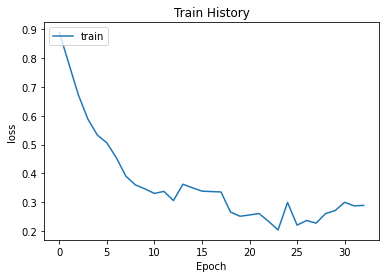

Test dice global: 0.7176670432090759


In [7]:
sample_indices = [i for i in range(len(ms_reader))]
kf = KFold(n_splits=5)
for fold_num, (train_indices, test_indices) in enumerate(kf.split(sample_indices)):
    print(f"Fold {fold_num+1}")
    model_save_name = f"save_model/Unet2D/Unet2D_fold{fold_num+1}.pth"
    #################
    # Train Dataset #
    #################
    dataset_train = MSDataset(ms_reader, train_indices, targetonly=False)
    data_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
            
    model = Unet2D(n_classes=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(patience=10)
    best_saver = BestSaver(model, model_save_name, best_criterion='min')
    train_history = []
    for epoch_num in range(epochs):    
        train_loss = train_one_epoch(model, optimizer, data_loader, device)
        if (epoch_num+1)%20 == 0:
            print(f"Epoch [{epoch_num+1}] loss: {train_loss}")
        # print(f"Epoch [{epoch_num+1}] loss: {train_loss}")
        
        if early_stopper.stopJudgment(train_loss):
            print(f"End in epoch {epoch_num+1}")
            break
        best_saver.saveJudgment(train_loss)
        train_history.append(train_loss)

    show_train_history(train_history)

    #################
    #  Test Dataset #
    #################
    dataset_test = MSDataset(ms_reader, test_indices, targetonly=False)
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=batch_size, shuffle=False)

    model.load_state_dict(torch.load(model_save_name))
    dice_global = evaluate(model, data_loader_test, device)
    print(f"Test dice global: {dice_global}")